# Imagenet Pipeline Profiling Analysis with Compression

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDD
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4


In [33]:
full_dataset_samplecount = 1281167
for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_samplecount * 100, 2)}%")

500 of total: 0.04%
1000 of total: 0.08%
2000 of total: 0.16%
4000 of total: 0.31%
8000 of total: 0.62%


In [34]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
compression_palette = sns.color_palette("Spectral",3)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
local_fig_dir = "imagenet-pipeline"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

home_path = "../logs/compression-logs/imagenet/"
path_to_cum_df = f"{home_path}/temp-a.csv"
path_to_cum_dstat_df = f"{home_path}/temp-b.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
# need to sort the strategies for some reason as they are not ascending
cum_df = cum_df.sort_values(by='split_name')
strategies   = list(cum_df.split_name.unique())
# removing the first strategy, as compression doesn't help when we read the unprocessed dataset from disk
strategies_renamed = ["concatenated", "decoded", "resized", "pixel-\ncentered"]

In [37]:
#cum_df
strategies

['2-read-image', '3-decode-image', '4-resize-image', '5-center-pixel-values']

In [38]:
cum_dstat_df.head(5)

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,...,vm_allocated_mb,vm_free_mb,filesystem_files,filesystem_inodes,filelocks_posix,filelocks_lock,filelocks_read,filelocks_write,compression_type,storage_type
0,0.0,0.042027,0.070618,0.000000,0.000000,0,1281167,8,8,656baf,...,0.02,0.02,1344.0,13791.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd
1,1.0,8.794112,0.000000,0.011931,0.003482,0,1281167,8,8,656baf,...,0.05,0.01,1344.0,13803.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd
2,2.0,0.274432,0.000000,3.044154,0.092238,0,1281167,8,8,656baf,...,0.06,0.00,1344.0,13917.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd
3,3.0,0.000000,0.000000,12.074411,0.240664,0,1281167,8,8,656baf,...,0.01,0.00,1344.0,14188.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd
4,4.0,0.000000,0.249856,12.547829,0.200786,0,1281167,8,8,656baf,...,0.01,0.00,1344.0,14407.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd


## 0. Experiment Information

### 0.1 Experiment Count

We want to profile each strategy with each compression at least 5 times. 

In [39]:
experiment_count_dict = {
    "split_name": []
  , "compression_type": []
  , "count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(split_name, compression_type, count):
    '''Short helper'''
    experiment_count_dict["split_name"] += [split_name]
    experiment_count_dict["compression_type"] += [compression_type]
    experiment_count_dict["count"] += [count]

for split_name in cum_df["split_name"].unique():
    for compression in cum_df["compression_type"].unique():
        experiment_count = get_experiment_count(cum_df.query(f"split_name=='{split_name}' and compression_type=='{compression}'"))
        add_to_dict(split_name, compression, experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

,split_name,compression_type,count
0,2-read-image,GZIP,1
1,2-read-image,none,2
2,2-read-image,ZLIB,1
3,3-decode-image,GZIP,1
4,3-decode-image,none,2
5,3-decode-image,ZLIB,1
6,4-resize-image,GZIP,1
7,4-resize-image,none,2
8,4-resize-image,ZLIB,1
9,5-center-pixel-values,GZIP,1


In [40]:
# order should be "none" -> "GZIP" -> "ZLIB"

cum_df_ord = cum_df.copy(deep=True)
order_dict = { "none": 10, "GZIP": 11, "ZLIB": 12 }
cum_df_ord = cum_df_ord.sort_values(by=['compression_type', 'split_name'], key=lambda x: x.map(order_dict))
cum_df_ord

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp,compression_type,storage_type
4,11648.557617,8,8,1.469521e+05,1281167,1035.774048,1236.917480,0,1,003f99,2-read-image,2021-09-29-19:51:17,none,ceph-hdd
8,12219.910156,8,8,1.469521e+05,1281167,1060.445190,1208.140747,0,1,ea3a36,2-read-image,2021-10-04-02:48:06,none,ceph-hdd
5,12052.949219,8,8,8.424820e+05,1281167,1617.729980,791.953552,0,1,b1e328,3-decode-image,2021-09-29-19:51:17,none,ceph-hdd
9,13705.187500,8,8,8.424820e+05,1281167,1956.157227,654.940735,0,1,00d26d,3-decode-image,2021-10-04-02:48:06,none,ceph-hdd
6,11694.620117,8,8,3.472968e+05,1281167,652.858948,1962.394775,0,1,42359b,4-resize-image,2021-09-29-19:51:17,none,ceph-hdd
10,17082.064453,8,8,3.472968e+05,1281167,779.940735,1642.646606,0,1,4db41b,4-resize-image,2021-10-04-02:48:06,none,ceph-hdd
7,12277.985352,8,8,1.388941e+06,1281167,2009.295044,637.620117,0,1,dbabf8,5-center-pixel-values,2021-09-29-19:51:17,none,ceph-hdd
11,17200.820312,8,8,1.388941e+06,1281167,2417.780029,529.893921,0,1,c2085a,5-center-pixel-values,2021-10-04-02:48:06,none,ceph-hdd
0,12471.334961,8,8,1.456724e+05,1281167,1147.127563,1116.847900,0,1,656baf,2-read-image,2021-10-02-06:48:10,GZIP,ceph-hdd
1,34137.796875,8,8,5.982059e+05,1281167,2172.999512,589.584595,0,1,4d3648,3-decode-image,2021-10-02-06:48:10,GZIP,ceph-hdd


# 3. Compression
## 3.1 Compression Rate for each strategy

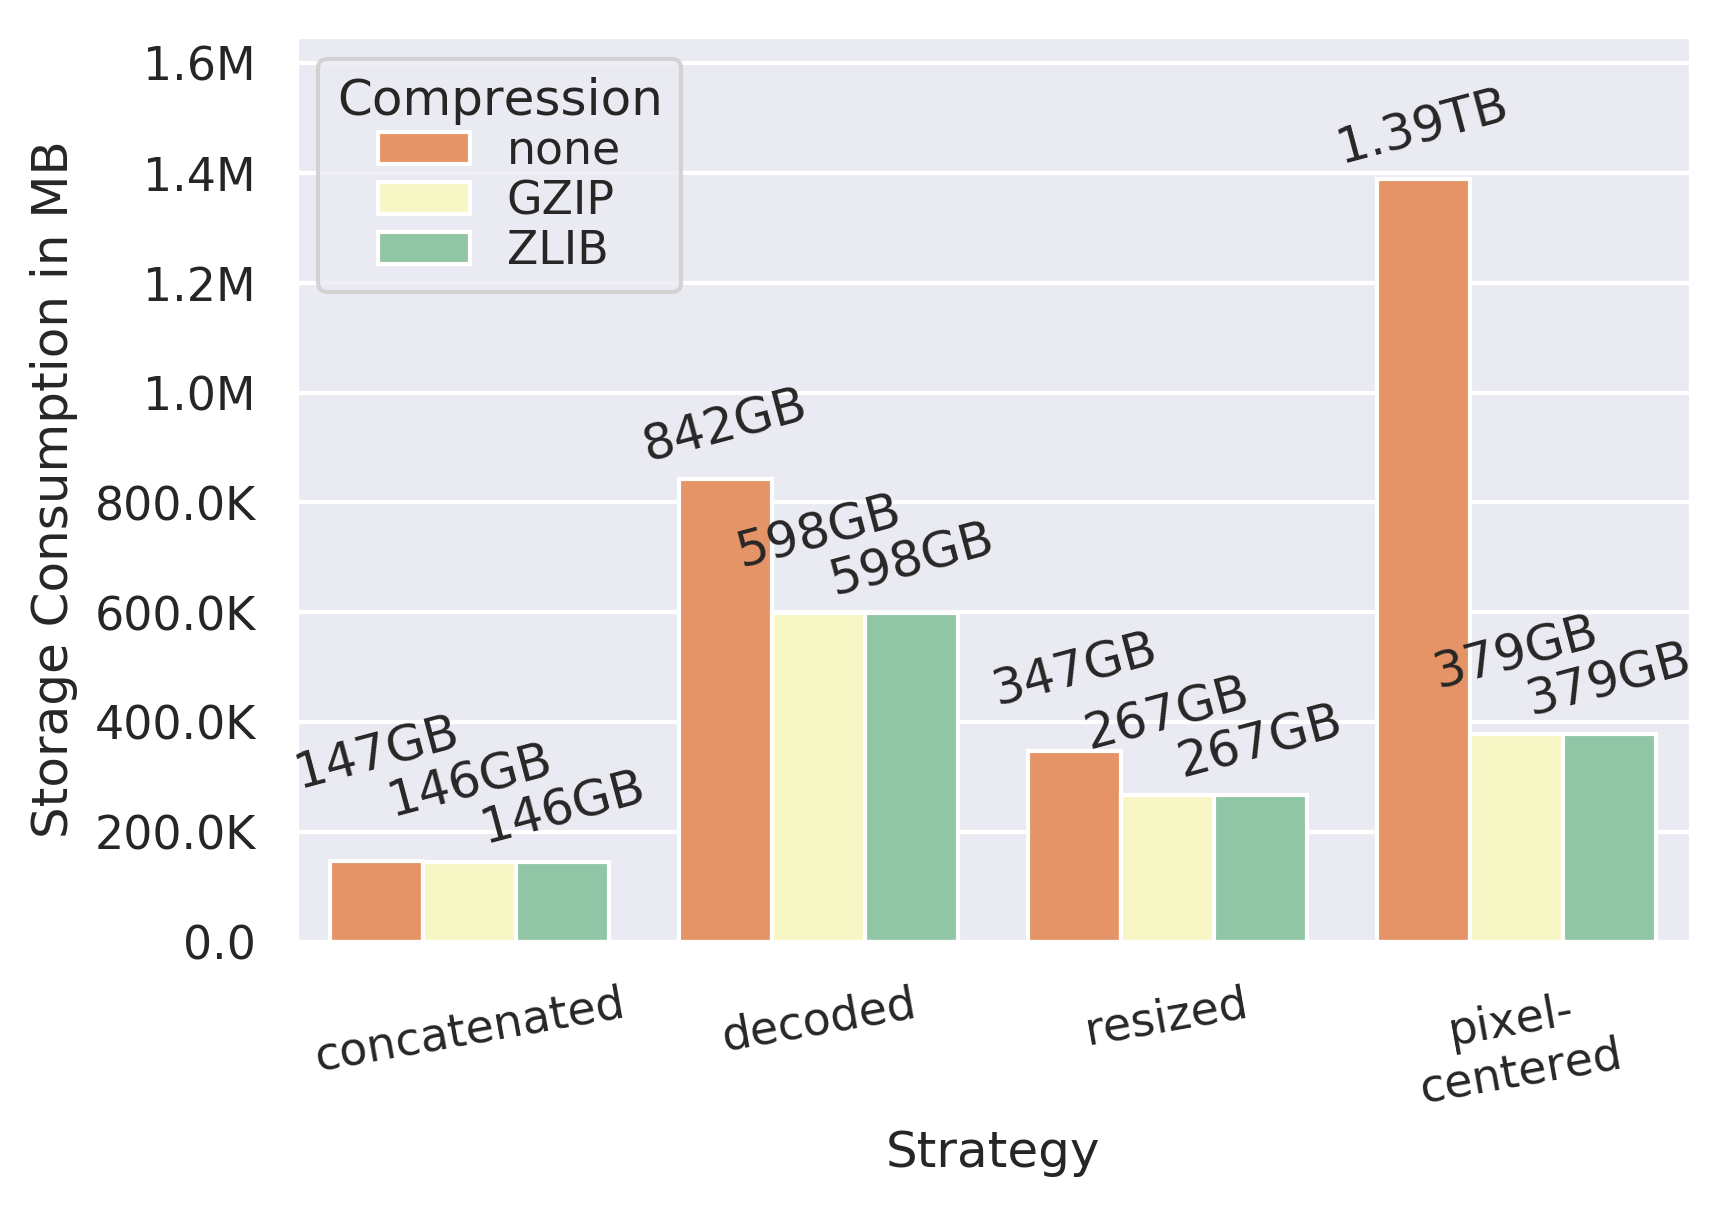

In [41]:
sns.set(palette=compression_palette)
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier


cum_df_temp = cum_df_ord

plot = sns.barplot(
    x="split_name",
    y="shard_cum_size_MB",
    hue="compression_type",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(ylim=(0, 1650000))
plot.set(xlabel="Strategy", ylabel="Storage Consumption in MB")
plot.legend(title="Compression", ncol=1, labelspacing=0.1)
plot.yaxis.set_major_formatter(make_big_number_prettier)
show_values_on_bars(plot, h_v="v", space=160000, rotation=15, storage_formatting=True, storage_round=0
                    , additional_space=[50000,-50000,0,-50000
                                       ,0,0,0,0
                                       ,-50000,-50000,-50000,-50000])

#save_fig("compressed-storage-consumption")

## 3.2 Storage and Throughput for each strategy

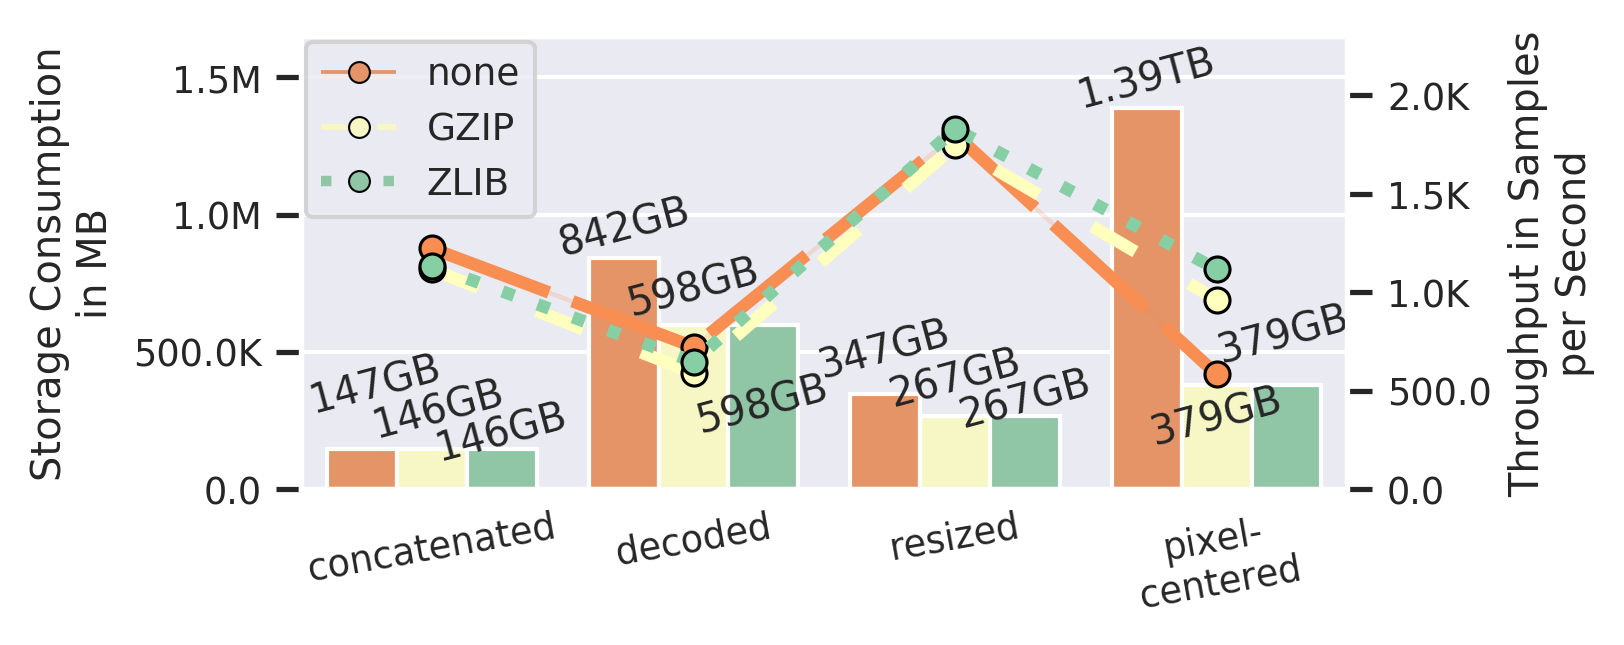

In [42]:
from matplotlib.lines import Line2D

sns.set(palette=compression_palette,font_scale=0.8)
marker = 'o'
linestyle = [(10,2), (4,5), (1,2)]
linestyle2 = [(0,(10,2)), (0,(4,5)), (0,(1,2))]

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()

## throughput plot
plot2 = sns.lineplot(
    x="split_name",
    y="throughput_sps",
    hue="compression_type",
    data=cum_df_temp,
    ax=ax2,
    size=3,
    sizes=(3,3),
    marker=marker,
    dashes=linestyle,
    ci=0.95,
    markeredgecolor='black',
    style='compression_type')

plot2.set(ylabel="Throughput in Samples\nper Second")
ax2.grid(False)
legend_elements = [
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=0.9, label='none', color="#E49467", linestyle=linestyle2[0]),
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=1.5, label='GZIP', color="#F7F7C6", linestyle=linestyle2[1]),
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=2.5, label='ZLIB', color="#90C6A6", linestyle=linestyle2[2])]
ax2.legend(handles=legend_elements, loc=(0.005,0.6), prop={'size': 9})
plot2.set(ylim=(0, 2300))          

plot = sns.barplot(
        x="split_name",
        y="shard_cum_size_MB",
        hue="compression_type",
        data=cum_df_temp,
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.yaxis.set_major_formatter(make_big_number_prettier)
show_values_on_bars(plot, h_v="v", space=80000, rotation=15, storage_formatting=True, storage_round=0,
                    additional_space=[175000,50000,100000,50000
                                     , 85000,75000, 75000,-175000
                                     ,     0,-350000,     0,125000]
                  , additional_x_space=[ 0.05,0,0,0
                                       ,0.025,0,0,0
                                       ,    0,0,0,-0.01])

plot.set(ylim=(0, 1650000))
ax1.get_legend().remove()
plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("compressed-storage-vs-throughput")

## 3.3 Throughput for each compression and each strategy

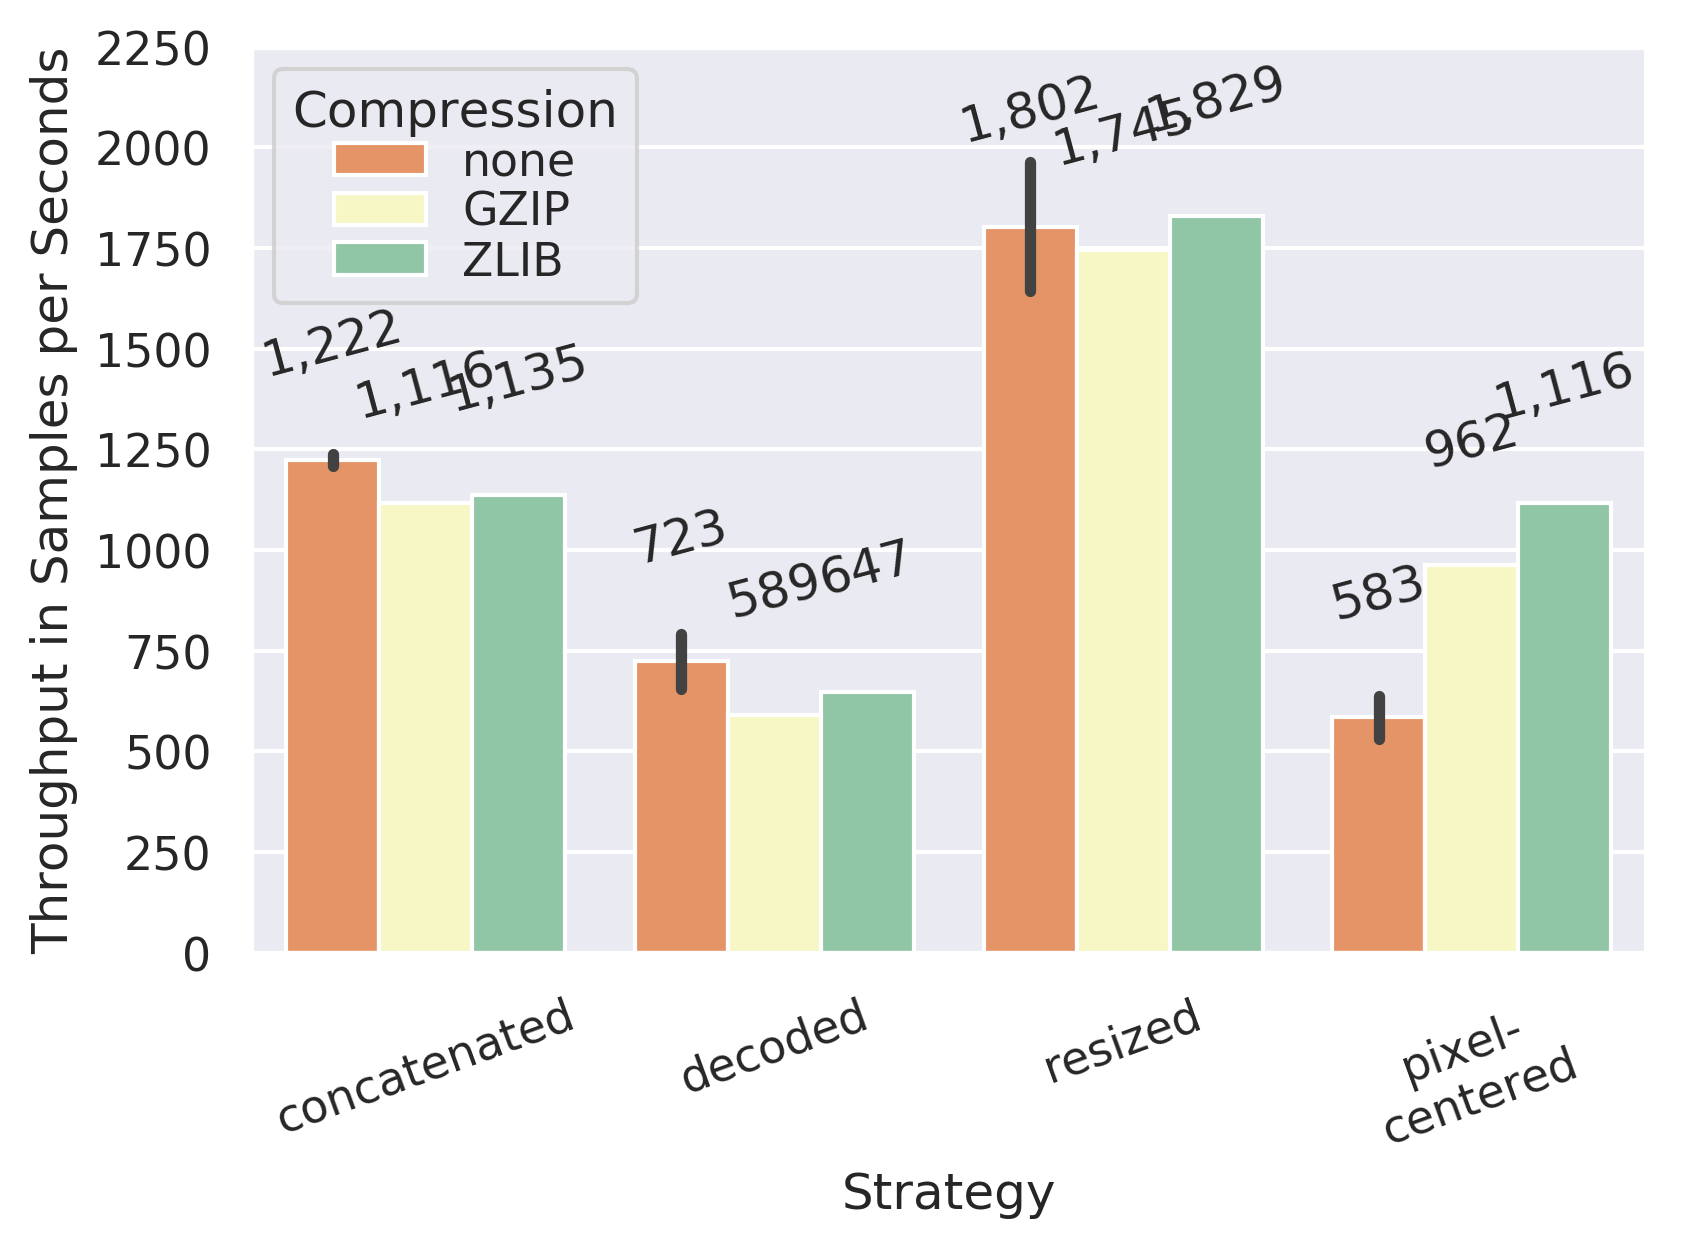

In [43]:
sns.set(palette=compression_palette)

cum_df_temp = cum_df_ord

plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="compression_type",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Seconds")
plot.set(ylim=(0, 2250))
plot.legend(title="Compression", ncol=1, labelspacing=0.1)
show_values_on_bars(plot, h_v="v", space=300, rotation=15)

#save_fig("compression-throughput")

## 3.3 Full Dataset Processing Split

### Normalizing the processing time per samples and renaming the maximum sample count to "full"

In [44]:
# calculate the per sample processing time for both offline and online processing
cum_df_ord["per_sample_online_processing_time_s"] = cum_df_ord["online_processing_time_s"] / cum_df_ord["sample_count"]
cum_df_ord["per_sample_offline_processing_and_save_time_s"] = cum_df_ord["offline_processing_and_save_time_s"] / cum_df_ord["sample_count"]
# calculate the total processing time for each sample count
cum_df_ord["total_processing_time_s"] = cum_df_ord["online_processing_time_s"] + cum_df_ord["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df_ord["full_dataset_online_processing_time_s"] = cum_df_ord["per_sample_online_processing_time_s"] * full_dataset_samplecount
cum_df_ord["full_dataset_offline_processing_and_save_time_s"] = cum_df_ord["per_sample_offline_processing_and_save_time_s"] * full_dataset_samplecount
cum_df_ord["full_dataset_offline_processing_and_save_time_m"] = cum_df_ord["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df_ord["full_dataset_offline_processing_and_save_time_h"] = cum_df_ord["full_dataset_offline_processing_and_save_time_m"] / 60

# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df_ord["full_dataset_processing_time_s"] = cum_df_ord["full_dataset_online_processing_time_s"] + cum_df_ord["full_dataset_offline_processing_and_save_time_s"]
cum_df_ord["full_dataset_processing_time_m"] = cum_df_ord["full_dataset_processing_time_s"] / 60
cum_df_ord["full_dataset_processing_time_h"] = cum_df_ord["full_dataset_processing_time_m"] / 60 

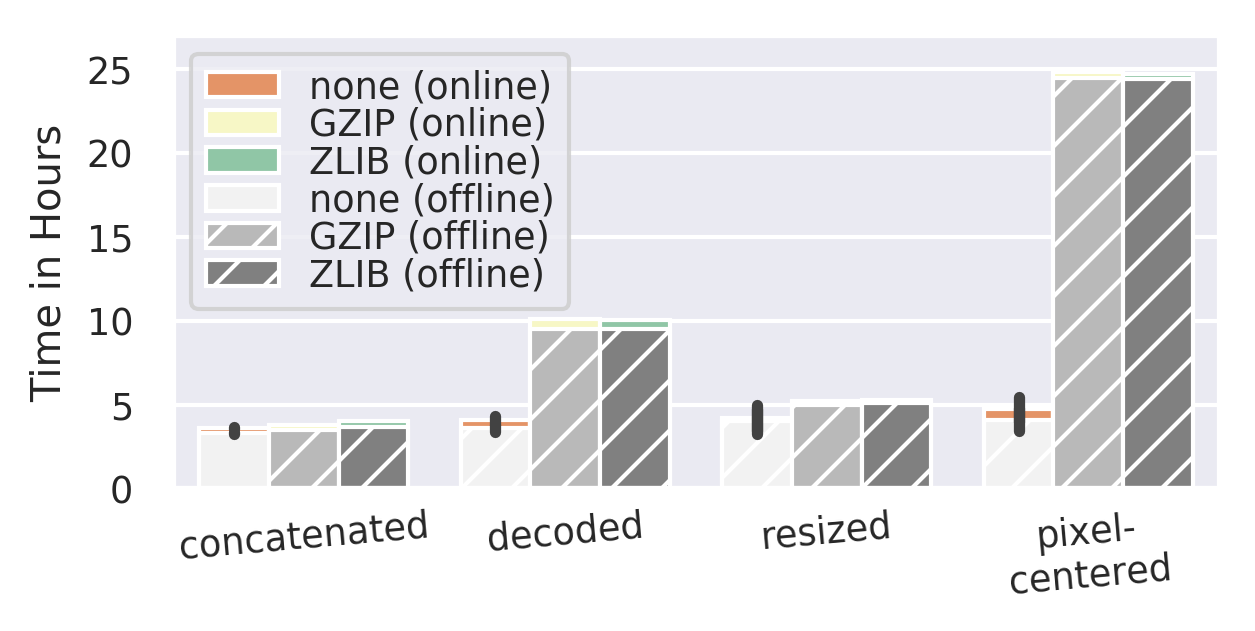

In [45]:
cum_df_temp = cum_df_ord
sns.set(palette=compression_palette, font_scale=0.8)
fig, ax1 = plt.subplots(figsize=(4.5,2))
plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_h",
    hue="compression_type",
    data=cum_df_temp
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_h",
    hue="compression_type",
    data=cum_df_temp,
    color="grey"
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=5
)
plot.tick_params(axis='x', which='major', pad=-1.5)
sample_counts = len(cum_df_temp.compression_type.unique())
strategies_count = len(cum_df_temp.split_name.unique())

for i,bar in enumerate(plot.patches):
    if i > (sample_counts * strategies_count):
        bar.set_hatch("//")

plot.set(xlabel="", ylabel="Time in Hours")
plot.set(ylim=(0, 27))

handles, labels = plot.get_legend_handles_labels()

def add_status_to_handle(handle, index):
    compression_count = 3
    label = handle.get_label()
    if index >= compression_count:
        new_label = label + ' (offline)'
    else:
        new_label = label + ' (online)'
    handle.set_label(new_label)
    
for i, handle in enumerate(handles):
    add_status_to_handle(handle,index=i)

plot.legend(handles=handles, title="", loc="upper left", ncol=1, labelspacing=0.02, columnspacing=0.3)
save_fig("compression-processing-time-split")

# X. Misc Plots and Calculations

## X.1 -

In [14]:
space_dict = {
    "strategy": []
   ,"space_saving_gzip": []
   ,"space_saving_zlib": []
   ,"sps_increase_gzip_fac": []
   ,"sps_increase_zlib_fac": []
}

def add_to_dict(strategy, ss_gzip, ss_zlib, sps_gzip, sps_zlib):
    space_dict["strategy"].append(strategy)
    space_dict["space_saving_gzip"].append(ss_gzip)
    space_dict["space_saving_zlib"].append(ss_zlib)
    space_dict["sps_increase_gzip_fac"].append(sps_gzip)
    space_dict["sps_increase_zlib_fac"].append(sps_zlib)
    
    
def space_saving(compressed, original):
    return round((1 - (compressed / original)) * 100, 2)

def throughput_increase(compressed, original):
    return round(compressed / original, 2)
    
for split_name in cum_df.split_name.unique():
    
    temp_df = cum_df.query(f"split_name=='{split_name}'")
    original_size = temp_df.query("compression_type=='none'").mean()["shard_cum_size_MB"]
    original_sps = temp_df.query("compression_type=='none'").mean()["throughput_sps"]
    gzip_size = temp_df.query("compression_type=='GZIP'").mean()["shard_cum_size_MB"]
    gzip_sps = temp_df.query("compression_type=='GZIP'").mean()["throughput_sps"]
    zlib_size = temp_df.query("compression_type=='ZLIB'").mean()["shard_cum_size_MB"]
    zlib_sps = temp_df.query("compression_type=='ZLIB'").mean()["throughput_sps"]

    print(f"Strategy: {split_name}")
    print(f"- Orig: {round(original_size, 2)}MB")
    print(f"- Orig: {round(original_sps, 2)}sps")
    print(f"- GZIP: {round(gzip_size, 2)}MB")
    print(f"- GZIP: {round(gzip_sps, 2)}sps")
    print(f"- ZLIB: {round(zlib_size, 2)}MB")    
    print(f"- ZLIB: {round(zlib_sps, 2)}sps")
    add_to_dict(strategy = split_name
               ,ss_gzip = space_saving(compressed = gzip_size, original = original_size)
               ,ss_zlib = space_saving(compressed = zlib_size, original = original_size)
               ,sps_gzip = throughput_increase(compressed = gzip_sps, original = original_sps)
               ,sps_zlib = throughput_increase(compressed = zlib_sps, original = original_sps))
    
pd.DataFrame(space_dict)    

Strategy: 2-read-image
- Orig: 146952.09MB
- Orig: 1222.53sps
- GZIP: 145672.39MB
- GZIP: 1116.85sps
- ZLIB: 145672.41MB
- ZLIB: 1135.94sps
Strategy: 3-decode-image
- Orig: 842482.0MB
- Orig: 723.45sps
- GZIP: 598205.94MB
- GZIP: 589.58sps
- ZLIB: 598206.88MB
- ZLIB: 647.85sps
Strategy: 4-resize-image
- Orig: 347296.75MB
- Orig: 1802.52sps
- GZIP: 267319.38MB
- GZIP: 1745.48sps
- ZLIB: 267317.84MB
- ZLIB: 1829.4sps
Strategy: 5-center-pixel-values
- Orig: 1388941.0MB
- Orig: 583.76sps
- GZIP: 378957.59MB
- GZIP: 962.58sps
- ZLIB: 378958.34MB
- ZLIB: 1116.72sps


,strategy,space_saving_gzip,space_saving_zlib,sps_increase_gzip_fac,sps_increase_zlib_fac
0,2-read-image,0.87,0.87,0.91,0.93
1,3-decode-image,28.99,28.99,0.81,0.90
2,4-resize-image,23.03,23.03,0.97,1.01
3,5-center-pixel-values,72.72,72.72,1.65,1.91


## X.2 Warning - Creating the plots based on `dstat` logs can take several hours

In [104]:
cum_dstat_df_copy = cum_dstat_df.copy(deep=True)
cum_dstat_df_copy["sample_count"] = cum_dstat_df_copy.sample_count.astype('category')
cum_dstat_df_copy["split_name"] = cum_dstat_df_copy.split_name.astype('category')
cum_dstat_df_copy["run"] = cum_dstat_df_copy.run.astype('category')
cum_dstat_df_copy["thread_count"] = cum_dstat_df_copy.thread_count.astype('category')
strategy_list = list(cum_dstat_df_copy.split_name.unique())
strategy_list

['2-read-image', '3-decode-image', '4-resize-image', '5-center-pixel-values']

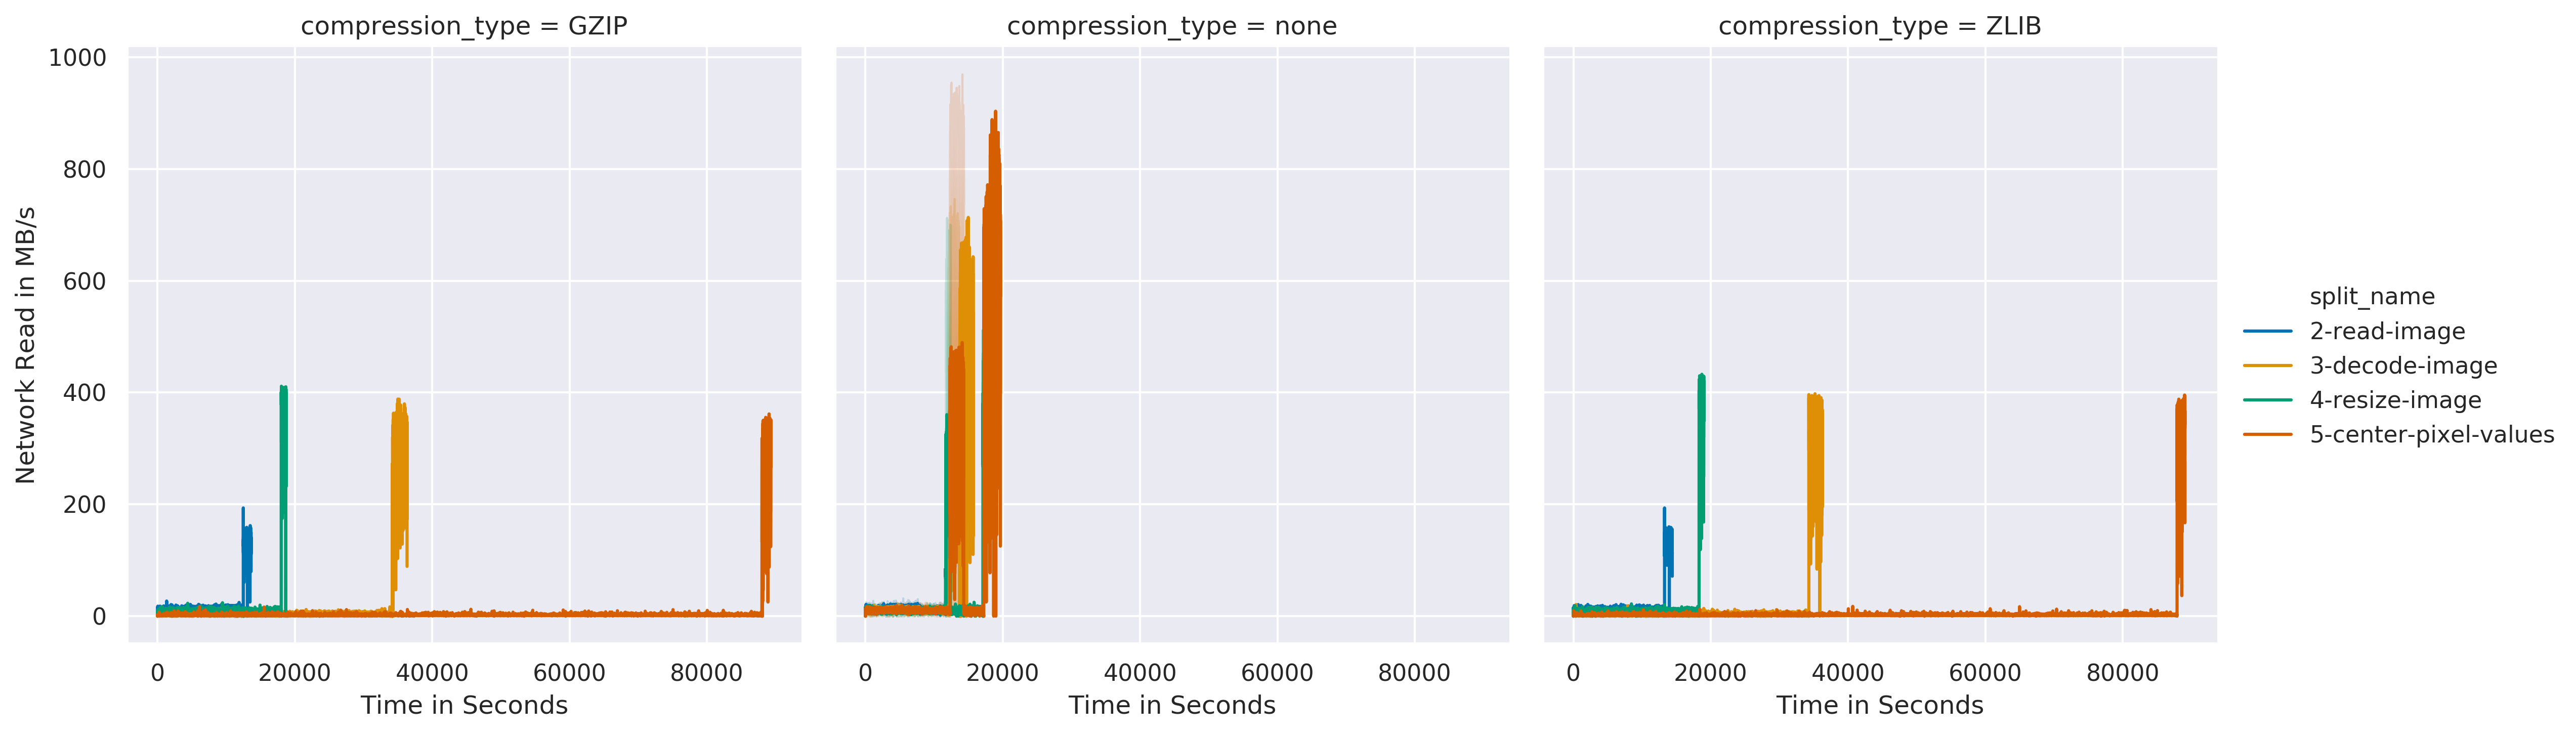

In [105]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy

plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="split_name",
    col="compression_type",
    kind="line",
    data=cum_dstat_df_temp,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

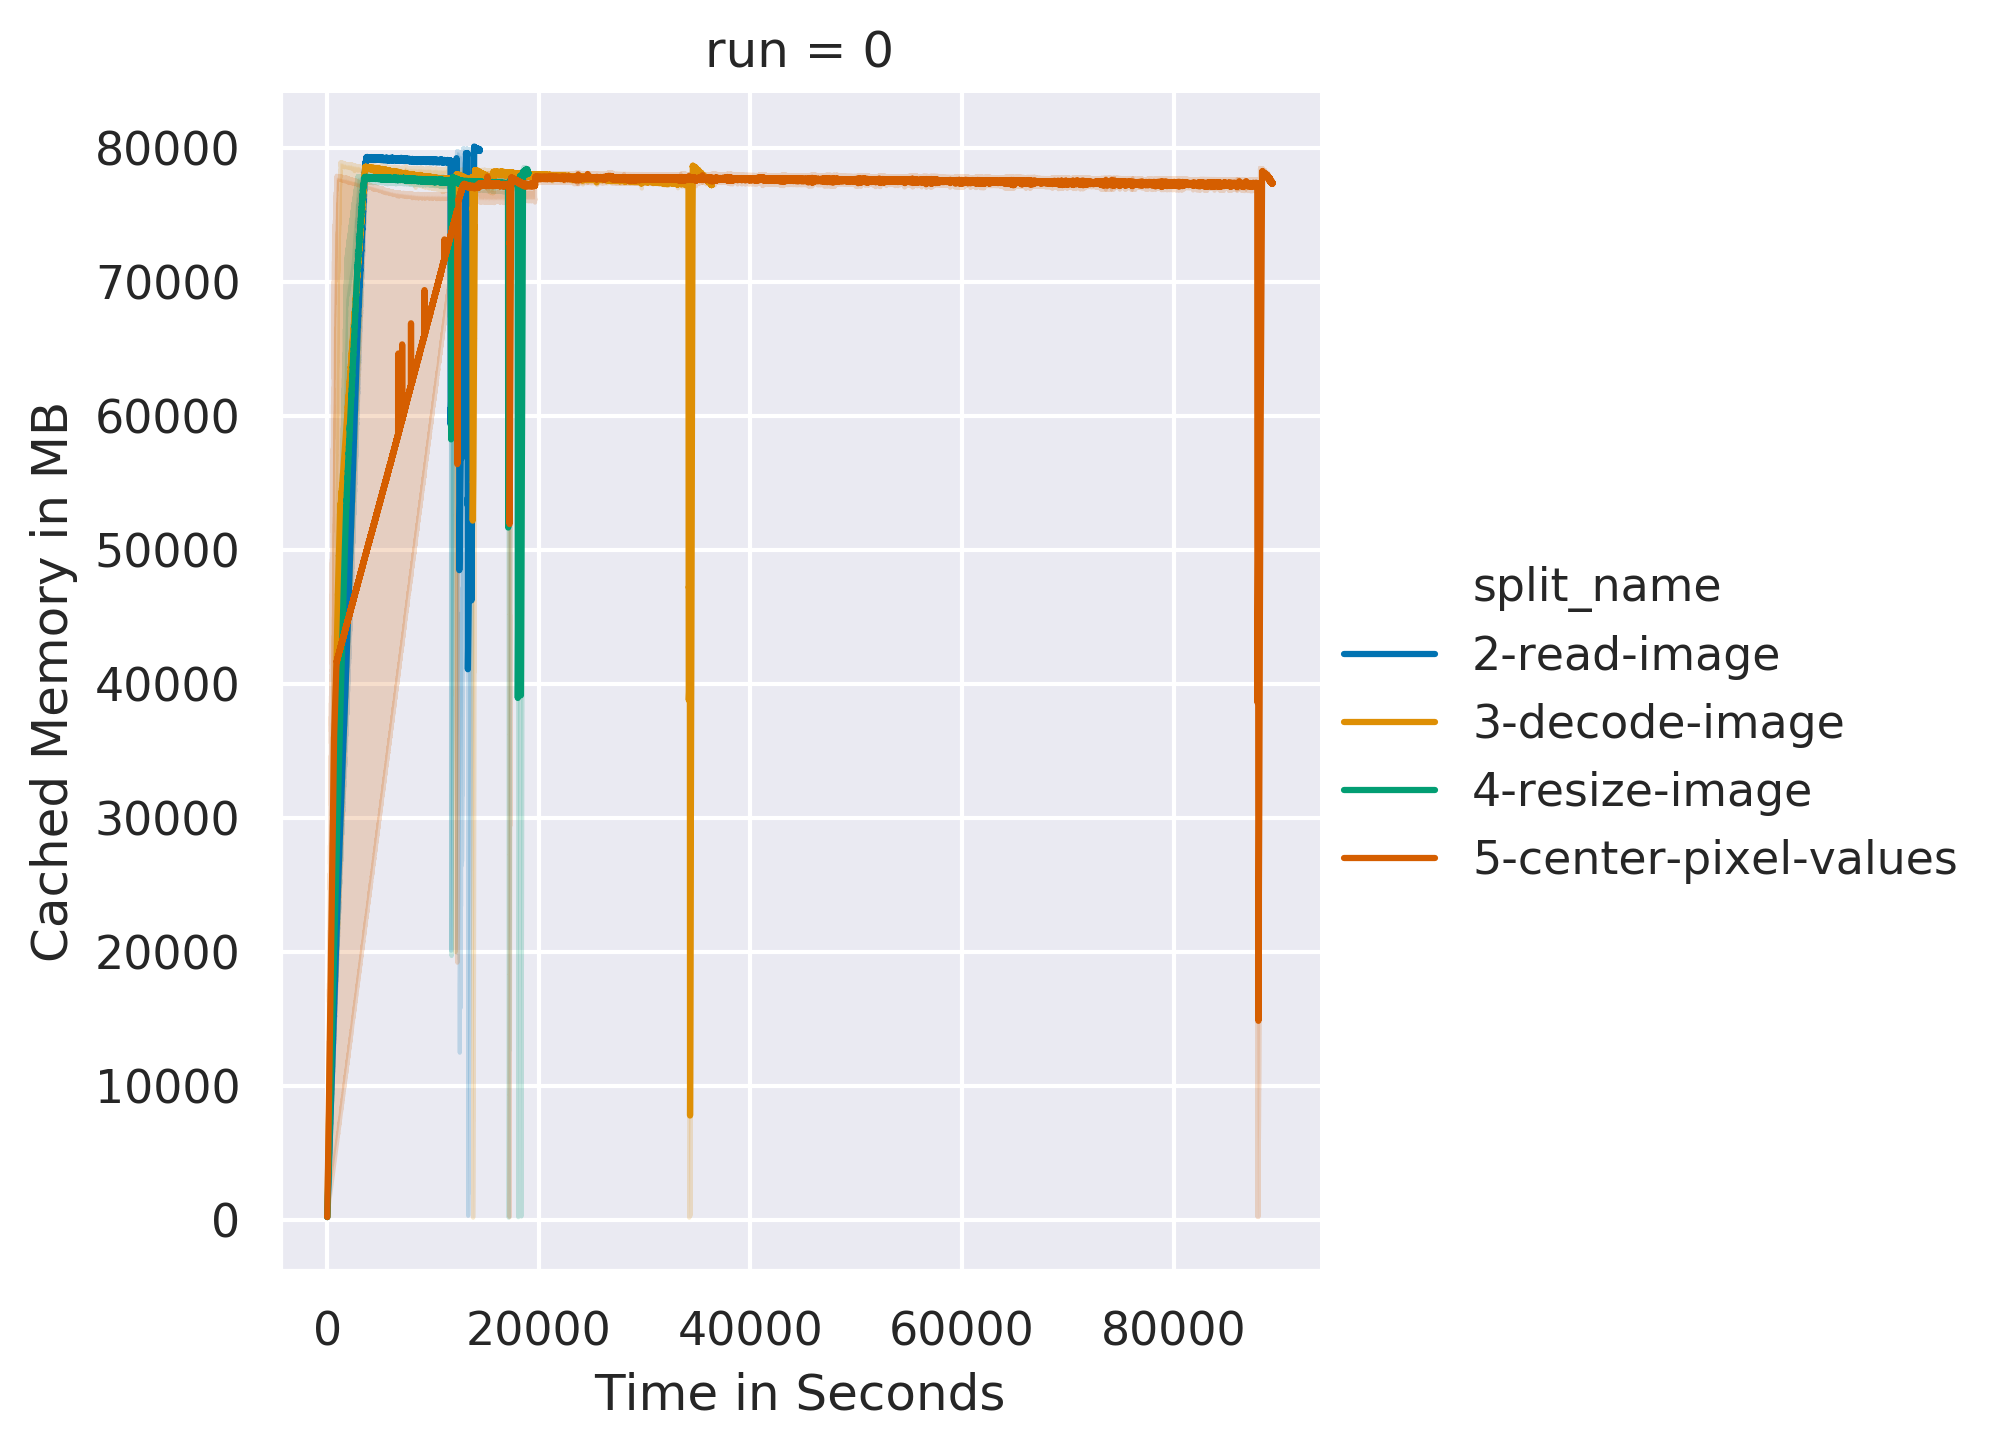

In [106]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy

plot = sns.relplot(
    x="rel_time_s",
    y="memory_cached_mb",
    hue="split_name",
    col="run",
    kind="line",
    data=cum_dstat_df_temp,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Cached Memory in MB")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")